In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

# model building
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Masking
from tensorflow.keras.metrics import RootMeanSquaredError
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Flatten
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dropout
from keras import layers
from tensorflow.keras import callbacks


2022-03-03 09:55:48.221054: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-03 09:55:48.221118: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Read in cleaned data

In [2]:
!pwd

/home/jakob/code/hmichinaka/berlin-bike-theft-forecasting/notebooks


In [3]:
df = pd.read_csv("../raw_data/bike_theft_cleaned.csv")

- No need for padding/masking here, as the sequences are of equal length 

# Group Dataframe by date and LOR

In [4]:
# Group dataframe by date and LOR
df_theft_model = df.pivot_table(index = "date_theft_start", columns = "Bezirk", values = "type_bike", aggfunc= "count")

df_theft_model.fillna(value = 0, inplace=True)

In [5]:
# create "total" column which sums up data for each day
df_theft_model["total"] = df_theft_model.sum(axis=1)

df_theft_model.shape

(424, 13)

In [6]:
df_theft_model.head()

Bezirk,1,2,3,4,5,6,7,8,9,10,11,12,total
date_theft_start,,,,,,,,,,,,,
2021-01-01,1.0,4.0,1.0,4.0,1.0,0.0,0.0,1.0,1.0,2.0,1.0,0.0,16.0
2021-01-02,0.0,0.0,5.0,3.0,0.0,1.0,1.0,2.0,2.0,0.0,1.0,1.0,16.0
2021-01-03,1.0,1.0,3.0,2.0,0.0,2.0,3.0,0.0,2.0,3.0,0.0,0.0,17.0
2021-01-04,6.0,7.0,3.0,4.0,0.0,2.0,4.0,3.0,1.0,0.0,1.0,2.0,33.0
2021-01-05,7.0,2.0,2.0,5.0,2.0,1.0,5.0,0.0,4.0,0.0,0.0,1.0,29.0


In [7]:
pd.date_range(start = df["date_theft_start"].min(), end = df["date_theft_start"].max()).difference(df_theft_model.index)

DatetimeIndex([], dtype='datetime64[ns]', freq=None)

# Build a baseline model predicting total of stolen bikes

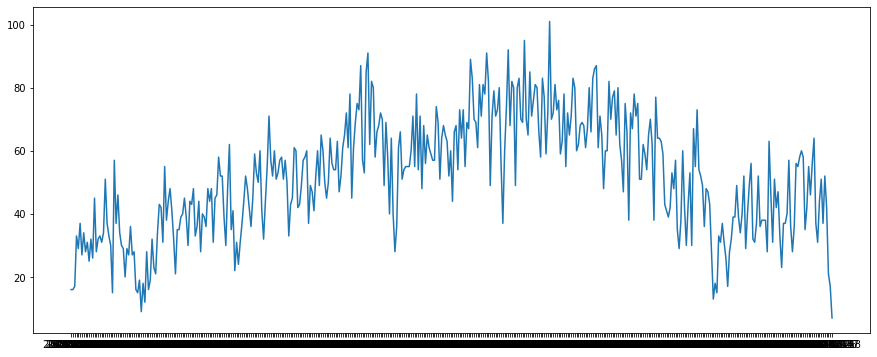

In [8]:
plt.figure(figsize=(15, 6))
plt.plot(df_theft_model["total"]);

## Create Train and Test Dataset

In [9]:
len(df_theft_model)

424

In [10]:
len_ = int(len(df_theft_model)*0.8)
len_

339

In [11]:
df_train = df_theft_model["total"][:len_]

In [12]:
df_test = df_theft_model["total"][len_:]

In [13]:
df_test.shape

(85,)

## Create Training and Test Arrays

In [14]:
def get_X_y(window_size, future_horizon, dataset):

  X = []
  y = []

  for i in range(0, dataset.shape[0] - window_size - future_horizon):
    X.append(dataset[i: i + window_size])
    y.append(dataset[i + window_size: i + window_size + future_horizon])

  return np.array(X), np.array(y)

In [15]:
window_size = 31
future_horizon = 1

X_train, y_train = get_X_y(window_size,future_horizon, df_train)
X_test, y_test = get_X_y(window_size, future_horizon, df_test)

In [16]:
X_train.shape

(307, 31)

In [17]:
X_test.shape

(53, 31)

In [18]:
X_test = np.expand_dims(X_test, 2)
X_train = np.expand_dims(X_train, 2)

In [19]:
X_train.shape

(307, 31, 1)

In [20]:
X_test.shape

(53, 31, 1)

# Finetuning

In [174]:
def model_create_compile(n_units_1 = 50, n_units_2 = 10, dropout_rate = 0.2):
    model = Sequential()
    # first LSTM layer
    model.add(LSTM(units = n_units_1, activation = "tanh", return_sequences = True))
    model.add(Dropout(dropout_rate))
    # second LSTM layer
    model.add(LSTM(units= n_units_2, activation= "tanh", return_sequences= False))
    model.add(Dropout(dropout_rate))

    # output layer to predict one value
    model.add(Dense(1, activation= "linear"))

    model.compile(optimizer= "adam", loss= "mse", metrics = "mean_absolute_percentage_error")

    return model

In [ ]:
es = callbacks.EarlyStopping(patience=5, restore_best_weights=True)

In [ ]:
model.fit(X_train, 
                y_train,
              batch_size=8, 
              epochs=300,
              validation_split=0.2,
              callbacks=[es], verbose = 1)

In [170]:
n_units_1 = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
n_units_2 = [10, 20, 30]
dropout_rate = [0.1, 0.2, 0.3] 

In [171]:
out = []

for i in n_units_1: 
    for j in n_units_2:
            for k in dropout_rate:
                out.append((i, j, k))

In [183]:
test = [["a", 2], ["b", 3]]
pd.DataFrame(test).sort_values(by = 1, ascending=False)

,0,1
1,b,3
0,a,2


In [175]:
result = []

for n in out:
    temp = []
    n_units_1, n_units_2, dropout_rate = n
    model = model_create_compile(n_units_1= n_units_1, n_units_2= n_units_2, dropout_rate=dropout_rate)
    temp.append(n_units_1)
    temp.append(n_units_2)
    temp.append(dropout_rate)
    
    cv_result = model_cross_validation(model)
    temp.append(np.mean(model_cross_validation, axis = 0)[1]))
    
    result.append(temp)

    

10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
90
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
